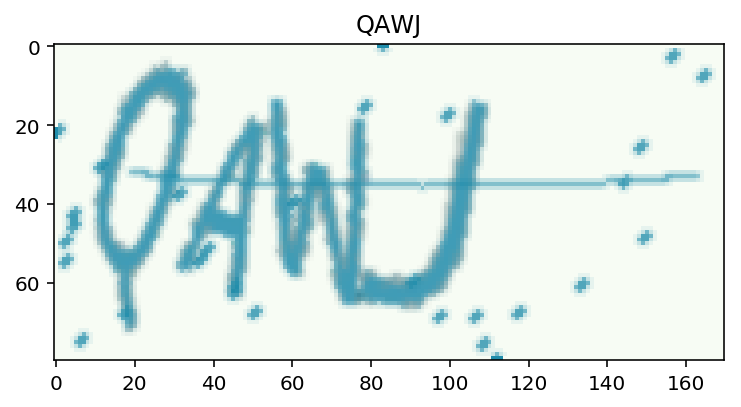

In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from captcha.image import ImageCaptcha

import string
characters = string.digits + string.ascii_uppercase

width, height, n_len, n_class = 170, 80, 4, len(characters)
generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)
plt.imshow(img)
plt.title(random_str)

In [2]:
width, height, n_len, n_class = 170, 80, 4, len(characters)

def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
#     y = np.zeros((batch_size, n_len, n_class))
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    
    while True:
        for i in range(batch_size):
            code = ''.join([random.choice(characters) for j in range(n_len)])
#             print("Generate Code:{}".format(code))
            X[i,:] = generator.generate_image(code)
            for j, s in enumerate(code):
                y[j][i, :] = 0
                y[j][i, characters.find(s)] = 1
        
        yield X, y

In [3]:
from keras.layers import *
from keras.models import *

inputs = Input(shape=(height, width, 3))

x = inputs
for i in range(4):
    x = Conv2D(filters=32*(2**i), kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=32*(2**i), kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax')(x) for i in range(n_len)]

model = Model(inputs=inputs, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['categorical_accuracy'])
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 80, 170, 3)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 80, 170, 32)   896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 80, 170, 32)   9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 40, 85, 32)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

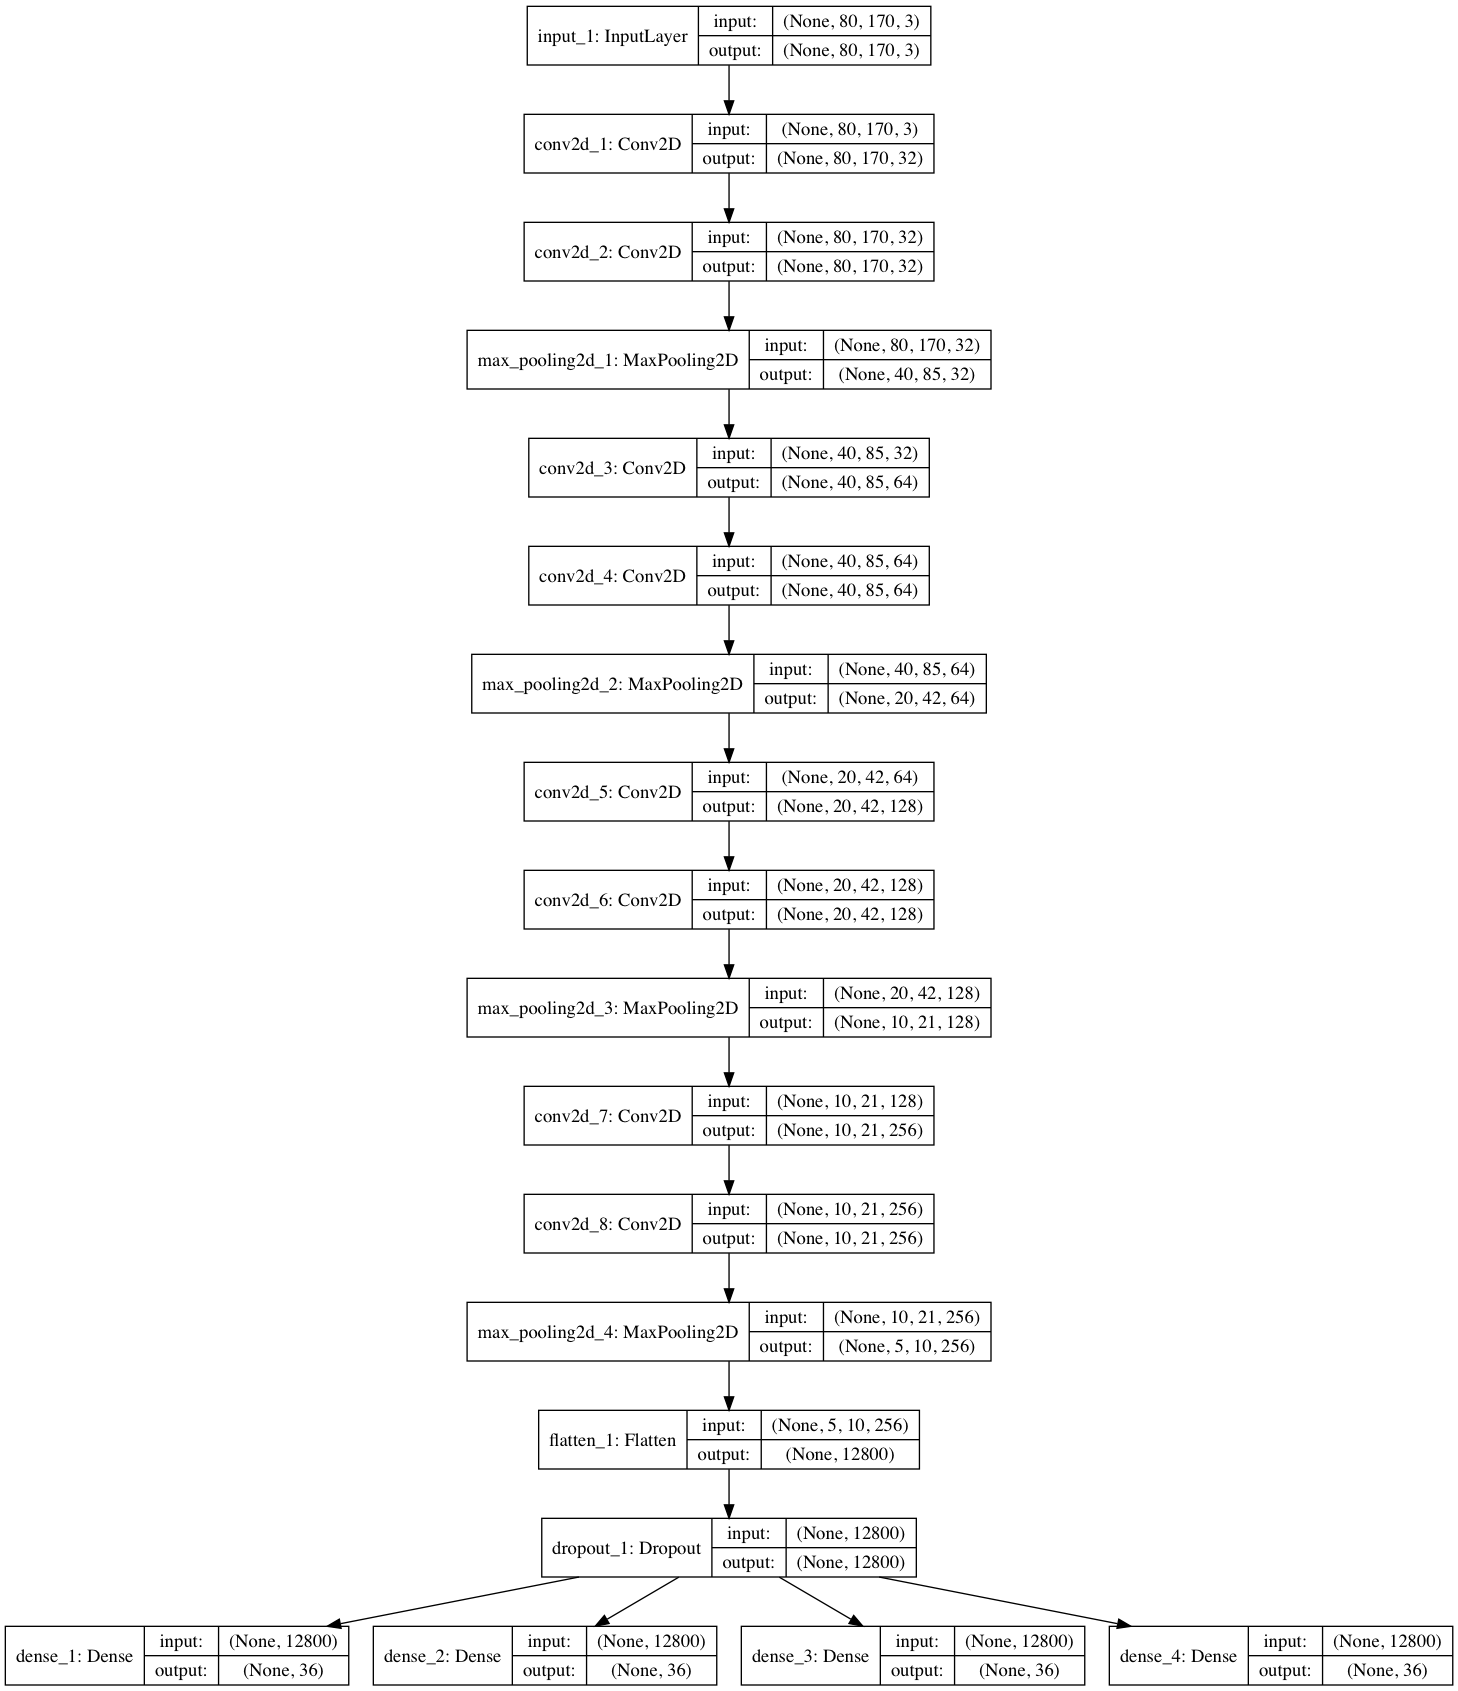

In [4]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file="./assets/model.png", show_shapes=True)
Image('./assets/model.png')

In [15]:
from keras.callbacks import *

# auto variable RUN
try:
    RUN += 1
except:
    RUN = 1

LOG_DIR = '/output/training_logs/run{}'.format(RUN)
LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'

EPOCHS = 128
STEPS_PER_EPOCH = 512

tensorboard = TensorBoard(log_dir=LOG_DIR, write_images=True)
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.fit_generator(gen(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, verbose=1, 
                    validation_data=gen(), validation_steps=64,
                    callbacks=[tensorboard, checkpoint, early_stopping])

Epoch 1/128
512/512 [==============================] - 61s - loss: 14.5643 - dense_33_loss: 3.6438 - dense_34_loss: 3.6352 - dense_35_loss: 3.6438 - dense_36_loss: 3.6414 - dense_33_categorical_accuracy: 0.0294 - dense_34_categorical_accuracy: 0.0286 - dense_35_categorical_accuracy: 0.0285 - dense_36_categorical_accuracy: 0.0273 - val_loss: 14.3373 - val_dense_33_loss: 3.5840 - val_dense_34_loss: 3.5837 - val_dense_35_loss: 3.5842 - val_dense_36_loss: 3.5853 - val_dense_33_categorical_accuracy: 0.0283 - val_dense_34_categorical_accuracy: 0.0352 - val_dense_35_categorical_accuracy: 0.0259 - val_dense_36_categorical_accuracy: 0.0205
Epoch 2/128
512/512 [==============================] - 59s - loss: 14.3361 - dense_33_loss: 3.5836 - dense_34_loss: 3.5843 - dense_35_loss: 3.5841 - dense_36_loss: 3.5841 - dense_33_categorical_accuracy: 0.0301 - dense_34_categorical_accuracy: 0.0273 - dense_35_categorical_accuracy: 0.0278 - dense_36_categorical_accuracy: 0.0283 - val_loss: 14.3346 - val_dens

512/512 [==============================] - 60s - loss: 0.8946 - dense_33_loss: 0.1814 - dense_34_loss: 0.2156 - dense_35_loss: 0.2758 - dense_36_loss: 0.2218 - dense_33_categorical_accuracy: 0.9712 - dense_34_categorical_accuracy: 0.9597 - dense_35_categorical_accuracy: 0.9426 - dense_36_categorical_accuracy: 0.9600 - val_loss: 0.7035 - val_dense_33_loss: 0.1416 - val_dense_34_loss: 0.1840 - val_dense_35_loss: 0.2150 - val_dense_36_loss: 0.1629 - val_dense_33_categorical_accuracy: 0.9756 - val_dense_34_categorical_accuracy: 0.9624 - val_dense_35_categorical_accuracy: 0.9570 - val_dense_36_categorical_accuracy: 0.9692
Epoch 8/128
512/512 [==============================] - 60s - loss: 0.7367 - dense_33_loss: 0.1515 - dense_34_loss: 0.1725 - dense_35_loss: 0.2333 - dense_36_loss: 0.1794 - dense_33_categorical_accuracy: 0.9743 - dense_34_categorical_accuracy: 0.9669 - dense_35_categorical_accuracy: 0.9497 - dense_36_categorical_accuracy: 0.9636 - val_loss: 0.7955 - val_dense_33_loss: 0.167

In [16]:
model.load_weights('/output/training_logs/run4/checkpoint-08-0.5285.hdf5')

In [17]:
def decode(ys):
    if len(ys) == 0:
        return []
    
    ys_list = []
    batch_size = ys[0].shape[0]
    for i in range(batch_size):
        code = ''.join([characters[np.argmax(ys[j][i])] for j in range(n_len)])
        ys_list.append(code)
    return ys_list

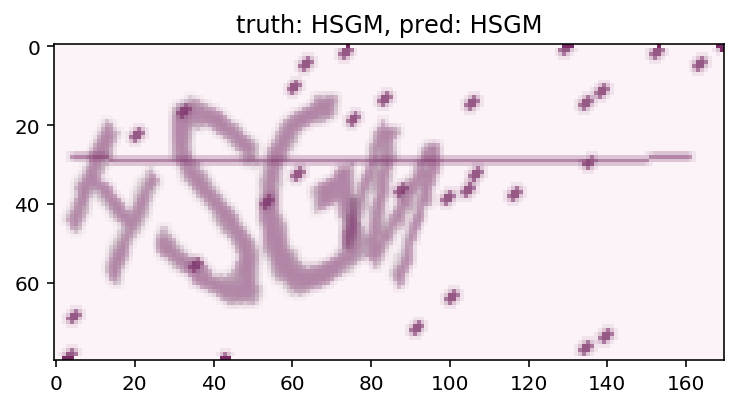

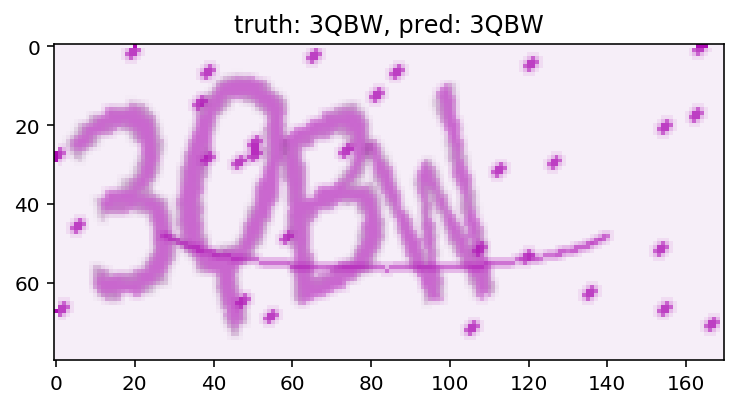

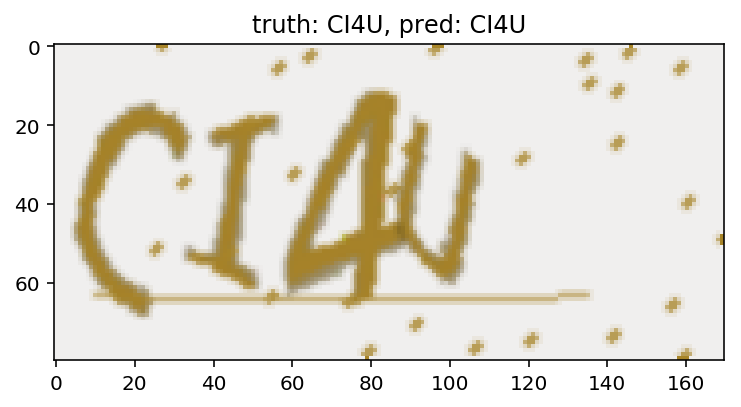

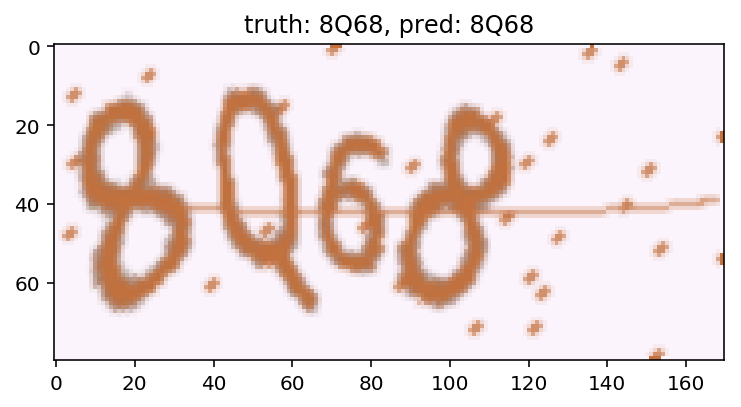

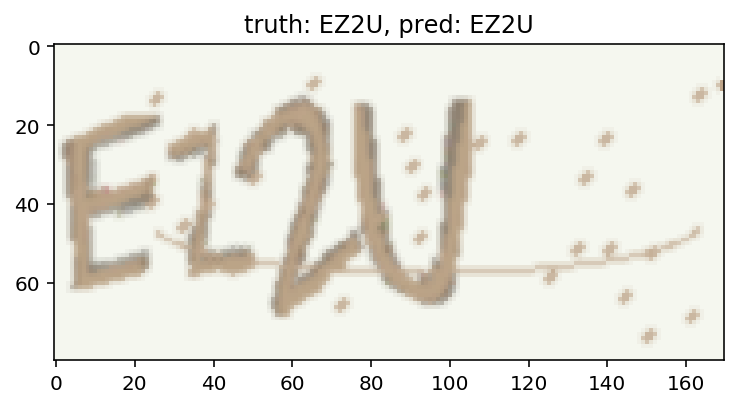

In [27]:
def test(i):
    X, y = next(gen(1))
    y_pred = model.predict(X)
    plt.figure(i)
    plt.title("truth: {}, pred: {}".format(decode(y)[0], decode(y_pred)[0]))
    plt.imshow(X[0])

for i in range(5):
    test(i)